In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
peaks = pd.read_csv('Hackathon2024.ATAC.txt', sep='\t') 

In [12]:
from sklearn.preprocessing import MinMaxScaler
peaks['sum'] = peaks.select_dtypes(include=[pd.np.number]).sum(axis=1)
peaks['variance'] = peaks.select_dtypes(include=[pd.np.number]).var(axis=1)
peaks['mean'] = peaks.select_dtypes(include=[pd.np.number]).mean(axis=1)
peaks['norm_mean'] = np.log(peaks['mean'])
peaks['norm_mean'].replace([np.inf, -np.inf], np.nan, inplace=True)
peaks['norm_mean'].fillna(peaks['norm_mean'].mean(), inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
peaks['norm_mean'] = scaler.fit_transform(peaks[['norm_mean']])

/var/folders/0v/5332h4d15q7cn_5xwjtkv2840000gn/T/ipykernel_43198/2381181505.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  peaks['sum'] = peaks.select_dtypes(include=[pd.np.number]).sum(axis=1)
/var/folders/0v/5332h4d15q7cn_5xwjtkv2840000gn/T/ipykernel_43198/2381181505.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  peaks['variance'] = peaks.select_dtypes(include=[pd.np.number]).var(axis=1)
/var/folders/0v/5332h4d15q7cn_5xwjtkv2840000gn/T/ipykernel_43198/2381181505.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  peaks['mean'] = peaks.select_dtypes(include=[pd.np.number]).mean(axis=1)
/Users/zs_jin/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered 

In [13]:
peak_features = peaks.iloc[:, 0].str.extract(r'(chr\d+|chrX|chrY)-(\d+)-(\d+)')
peak_features.columns = ['chromosome', 'start', 'end']
peak_features[['start', 'end']] = peak_features[['start', 'end']].astype(int)
peak_features['length'] = peak_features['end'] - peak_features['start']
peaks = pd.concat([peaks.iloc[:, 0:], peak_features], axis=1)
peaks['norm_sum'] = peaks['sum']/peaks['length'] #normalized by length as chatgpt suggested

In [14]:
print(peaks.head())

                 peak  AAACCAACACAATGCC.1  AAACCAACAGGAACTG.1  \
0    chr1-10109-10357                   0                   0   
1  chr1-180730-181630                   0                   0   
2  chr1-191491-191736                   0                   0   
3  chr1-267816-268196                   0                   2   
4  chr1-586028-586373                   0                   0   

   AAACCAACATAATCCG.1  AAACCAACATTGTGCA.1  AAACCGCGTACTTCAC.1  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   AAACCGGCATAATCAC.1  AAACGCGCAGCAAGAT.1  AAACGGATCCCATAGG.1  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0  

In [15]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score

gmm = GaussianMixture(n_components=20, random_state=42)

X = peaks['norm_sum'].values.reshape(-1, 1)

silhouette_scores = []
calinski_scores = []
n_components_range = range(10, 18)

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=58)
    labels = gmm.fit_predict(X)

    silhouette_avg = silhouette_score(X, labels)
    calinski_harabasz = calinski_harabasz_score(X, labels)
    
    silhouette_scores.append(silhouette_avg)
    calinski_scores.append(calinski_harabasz)

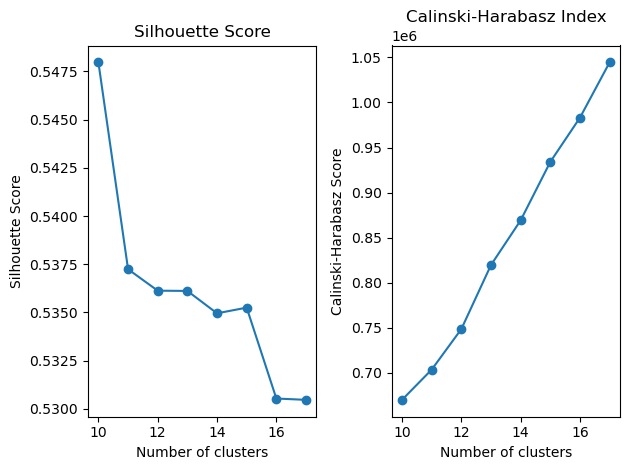

In [16]:
plt.subplot(1, 2, 1)
plt.plot(n_components_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.subplot(1, 2, 2)
plt.plot(n_components_range, calinski_scores, marker='o')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Score')

plt.tight_layout()
plt.show()

/var/folders/0v/5332h4d15q7cn_5xwjtkv2840000gn/T/ipykernel_43198/4065387716.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gmm_bin', data=peaks, palette='coolwarm')


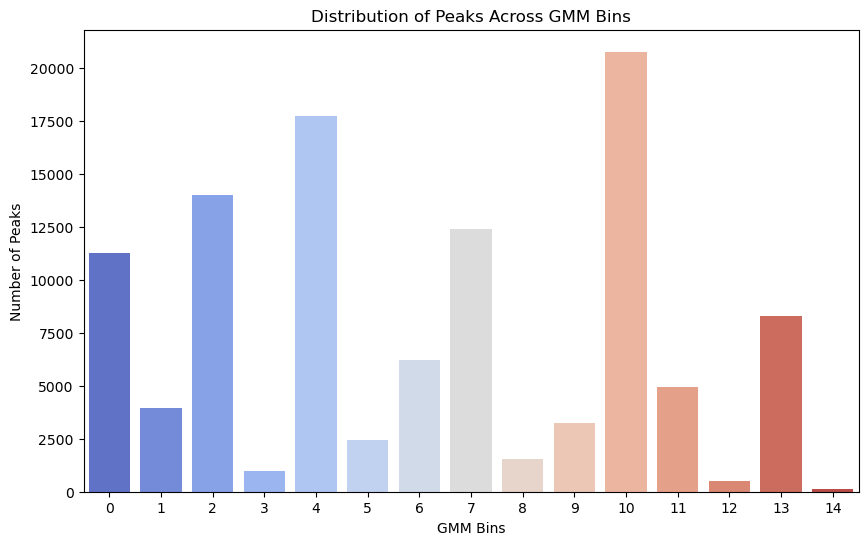

In [18]:
gmm = GaussianMixture(n_components=15, random_state=58)
labels = gmm.fit_predict(X)

peaks['gmm_bin'] = gmm.predict(peaks['norm_sum'].values.reshape(-1, 1))

plt.figure(figsize=(10, 6))
sns.countplot(x='gmm_bin', data=peaks, palette='coolwarm')
plt.title('Distribution of Peaks Across GMM Bins')
plt.xlabel('GMM Bins')
plt.ylabel('Number of Peaks')
plt.show()

In [19]:
peaks_extract = peaks[['peak','chromosome', 'start', 'end', 'length', 'sum', 'mean', 'variance', 'norm_mean', 'norm_sum', 'gmm_bin']]
print(peaks_extract.head())

                 peak chromosome   start     end  length  sum      mean  \
0    chr1-10109-10357       chr1   10109   10357     248   27  0.018080   
1  chr1-180730-181630       chr1  180730  181630     900   78  0.052678   
2  chr1-191491-191736       chr1  191491  191736     245   42  0.028193   
3  chr1-267816-268196       chr1  267816  268196     380  113  0.076751   
4  chr1-586028-586373       chr1  586028  586373     345   68  0.045846   

   variance  norm_mean  norm_sum  gmm_bin  
0  0.258429   0.241863  0.108871        4  
1  2.086658   0.320233  0.086667        4  
2  0.608085   0.274422  0.171429        2  
3  4.328434   0.347815  0.297368        7  
4  1.585140   0.310054  0.197101        2  


In [20]:
peaks_extract.to_csv('ATAC_features.csv')